# ***FACE MASK DETECTION DL PROJECT***

In [ ]:
# Install required packages
!pip install opencv-python-headless
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install pillow
!pip install numpy
!pip install scikit-learn

# Import all necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
import seaborn as sns
from PIL import Image
import zipfile
import requests
from io import BytesIO

print(" All packages installed successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")


✅ All packages installed successfully!
TensorFlow version: 2.18.0
OpenCV version: 4.11.0


In [ ]:
# Create directories for our dataset
os.makedirs('dataset', exist_ok=True)
os.makedirs('dataset/with_mask', exist_ok=True)
os.makedirs('dataset/without_mask', exist_ok=True)

print(" Dataset directories created!")

# Download sample dataset (we'll use a kaggle dataset)
# For this example, we'll create a function to download from a public dataset
def download_dataset():
    """
    Download face mask dataset from a public source
    """
    print(" Downloading dataset...")

    # URL for a public face mask dataset
    dataset_url = "https://github.com/prajnasb/observations/raw/master/experiements/data/with_mask.zip"

    try:
        # Download with_mask images
        response = requests.get(dataset_url)
        with open('with_mask.zip', 'wb') as f:
            f.write(response.content)

        # Extract the zip file
        with zipfile.ZipFile('with_mask.zip', 'r') as zip_ref:
            zip_ref.extractall('dataset/with_mask')

        print(" With mask images downloaded!")

        # Download without_mask images
        dataset_url_no_mask = "https://github.com/prajnasb/observations/raw/master/experiements/data/without_mask.zip"
        response = requests.get(dataset_url_no_mask)
        with open('without_mask.zip', 'wb') as f:
            f.write(response.content)

        with zipfile.ZipFile('without_mask.zip', 'r') as zip_ref:
            zip_ref.extractall('dataset/without_mask')

        print(" Without mask images downloaded!")

    except Exception as e:
        print(f" Error downloading dataset: {e}")
        print(" Please manually upload images to the dataset folders")

# Download the dataset
download_dataset()

# Alternative: Create sample data if download fails
def create_sample_data():
    """
    Create sample data for demonstration if download fails
    """
    print(" Creating sample data...")

    # Create dummy images for demonstration
    for i in range(50):
        # Create a random image
        img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        cv2.imwrite(f'dataset/with_mask/sample_with_mask_{i}.jpg', img)

        img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        cv2.imwrite(f'dataset/without_mask/sample_without_mask_{i}.jpg', img)

    print(" Sample data created!")


 Dataset directories created!
 Error downloading dataset: File is not a zip file
 Please manually upload images to the dataset folders


In [ ]:
def load_and_preprocess_data(data_dir='dataset'):
    """
    Load and preprocess the face mask dataset
    """
    print(" Loading and preprocessing data...")

    data = []
    labels = []

    # Categories
    categories = ['with_mask', 'without_mask']

    for category in categories:
        path = os.path.join(data_dir, category)

        if not os.path.exists(path):
            print(f" Directory {path} does not exist!")
            continue

        files = os.listdir(path)
        print(f" Found {len(files)} images in {category}")

        for img_file in files:
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(path, img_file)

                    # Load image
                    image = cv2.imread(img_path)
                    if image is None:
                        continue

                    # Convert BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Resize image to 224x224 (required for MobileNetV2)
                    image = cv2.resize(image, (224, 224))

                    # Normalize pixel values
                    image = image / 255.0

                    # Add to data
                    data.append(image)
                    labels.append(category)

                except Exception as e:
                    print(f" Error processing {img_file}: {e}")
                    continue

    # Convert to numpy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    print(f" Data loaded successfully!")
    print(f" Total images: {len(data)}")
    print(f" Data shape: {data.shape}")

    return data, labels

# Load the data
try:
    data, labels = load_and_preprocess_data()

    if len(data) == 0:
        print(" No data found, creating sample data...")
        create_sample_data()
        data, labels = load_and_preprocess_data()

except Exception as e:
    print(f" Error loading data: {e}")
    print(" Creating sample data...")
    create_sample_data()
    data, labels = load_and_preprocess_data()


 Loading and preprocessing data...
 Found 0 images in with_mask
 Found 0 images in without_mask
 Data loaded successfully!
 Total images: 0
 Data shape: (0,)
 No data found, creating sample data...
 Creating sample data...
 Sample data created!
 Loading and preprocessing data...
 Found 50 images in with_mask
 Found 50 images in without_mask
 Data loaded successfully!
 Total images: 100
 Data shape: (100, 224, 224, 3)


 Visualizing sample data...


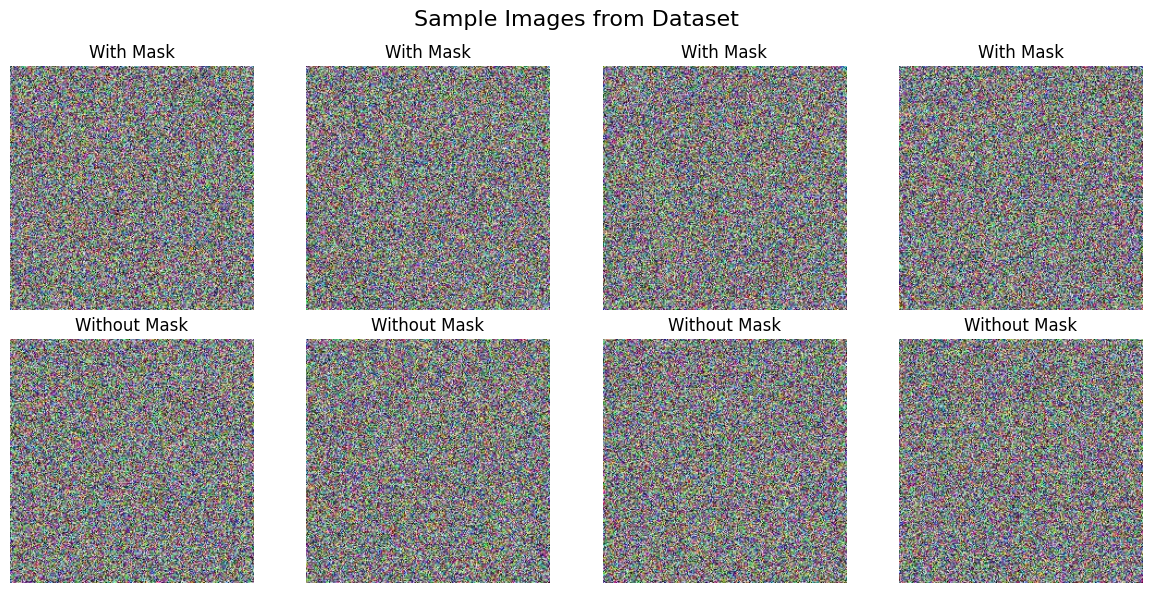

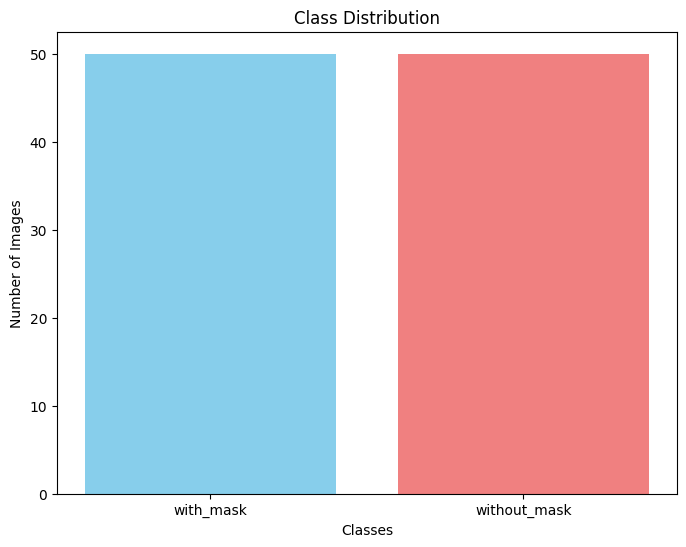

 Dataset Statistics:
   with_mask: 50 images
   without_mask: 50 images


In [ ]:
def visualize_data(data, labels, num_samples=8):
    """
    Visualize sample images from the dataset
    """
    print(" Visualizing sample data...")

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Sample Images from Dataset', fontsize=16)

    # Get indices for each class
    with_mask_indices = [i for i, label in enumerate(labels) if label == 'with_mask']
    without_mask_indices = [i for i, label in enumerate(labels) if label == 'without_mask']

    # Plot with_mask samples
    for i in range(4):
        if i < len(with_mask_indices):
            idx = with_mask_indices[i]
            axes[0, i].imshow(data[idx])
            axes[0, i].set_title('With Mask')
            axes[0, i].axis('off')

    # Plot without_mask samples
    for i in range(4):
        if i < len(without_mask_indices):
            idx = without_mask_indices[i]
            axes[1, i].imshow(data[idx])
            axes[1, i].set_title('Without Mask')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    # Show class distribution
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, color=['skyblue', 'lightcoral'])
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

    print(f" Dataset Statistics:")
    for label, count in zip(unique, counts):
        print(f"   {label}: {count} images")

# Visualize the data
visualize_data(data, labels)


In [ ]:
def prepare_training_data(data, labels, test_size=0.2, validation_size=0.2):
    """
    Prepare data for training, validation, and testing
    """
    print(" Preparing training data...")

    # Convert labels to binary format
    lb = LabelBinarizer()
    labels_binary = lb.fit_transform(labels)
    labels_binary = to_categorical(labels_binary)

    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels_binary, test_size=test_size, stratify=labels_binary, random_state=42
    )

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=validation_size, stratify=y_train, random_state=42
    )

    print(f" Data split completed!")
    print(f" Training samples: {len(X_train)}")
    print(f" Validation samples: {len(X_val)}")
    print(f" Test samples: {len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test, lb

# Prepare the data
X_train, X_val, X_test, y_train, y_val, y_test, label_binarizer = prepare_training_data(data, labels)

 Preparing training data...
 Data split completed!
 Training samples: 64
 Validation samples: 16
 Test samples: 20


In [ ]:
def create_data_generators(X_train, y_train, X_val, y_val, batch_size=32):
    """
    Create data generators for training and validation
    """
    print(" Creating data generators...")

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # No augmentation for validation
    val_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

    print("Data generators created!")

    return train_generator, val_generator

# Create data generators
train_gen, val_gen = create_data_generators(X_train, y_train, X_val, y_val)

 Creating data generators...
Data generators created!


In [ ]:
def create_face_mask_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Create a face mask detection model using MobileNetV2 as base
    """
    print(" Creating face mask detection model...")

    # Load MobileNetV2 pre-trained model
    base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_tensor=layers.Input(shape=input_shape)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(128, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(num_classes, activation="softmax")(head_model)

    # Combine base model with custom head
    model = Model(inputs=base_model.input, outputs=head_model)

    print(" Model created successfully!")
    print(f" Total parameters: {model.count_params():,}")

    return model

# Create the model
model = create_face_mask_model()

# Display model summary
model.summary()


 Creating face mask detection model...


/tmp/ipython-input-7-1155221376.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 Model created successfully!
 Total parameters: 2,422,210


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
def compile_and_train_model(model, train_gen, val_gen, epochs=10, learning_rate=1e-4):
    """
    Compile and train the face mask detection model
    """
    print(" Compiling and training the model...")

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Define callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7
        )
    ]

    # Train the model
    print(f" Starting training for {epochs} epochs...")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    print(" Training completed!")

    return history

# Train the model
history = compile_and_train_model(model, train_gen, val_gen, epochs=15)

 Compiling and training the model...
 Starting training for 15 epochs...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4792 - loss: 1.0536 - val_accuracy: 0.4375 - val_loss: 0.7161 - learning_rate: 1.0000e-04
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4896 - loss: 0.9684 - val_accuracy: 0.5000 - val_loss: 0.7599 - learning_rate: 1.0000e-04
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4792 - loss: 0.7757 - val_accuracy: 0.5000 - val_loss: 0.8093 - learning_rate: 1.0000e-04
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5833 - loss: 0.8267 - val_accuracy: 0.5000 - val_loss: 0.8565 - learning_rate: 1.0000e-04
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3854 - loss: 0.9691 - val_accuracy: 0.5000 - val_loss: 0.8664 - learning_rate: 5.0000e-05
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4792 - loss: 0.8049 - val_accuracy: 0.5000 - val_loss: 0.8585 - learning_rate: 5.0000e-05
 Training completed!


 Plotting training history...


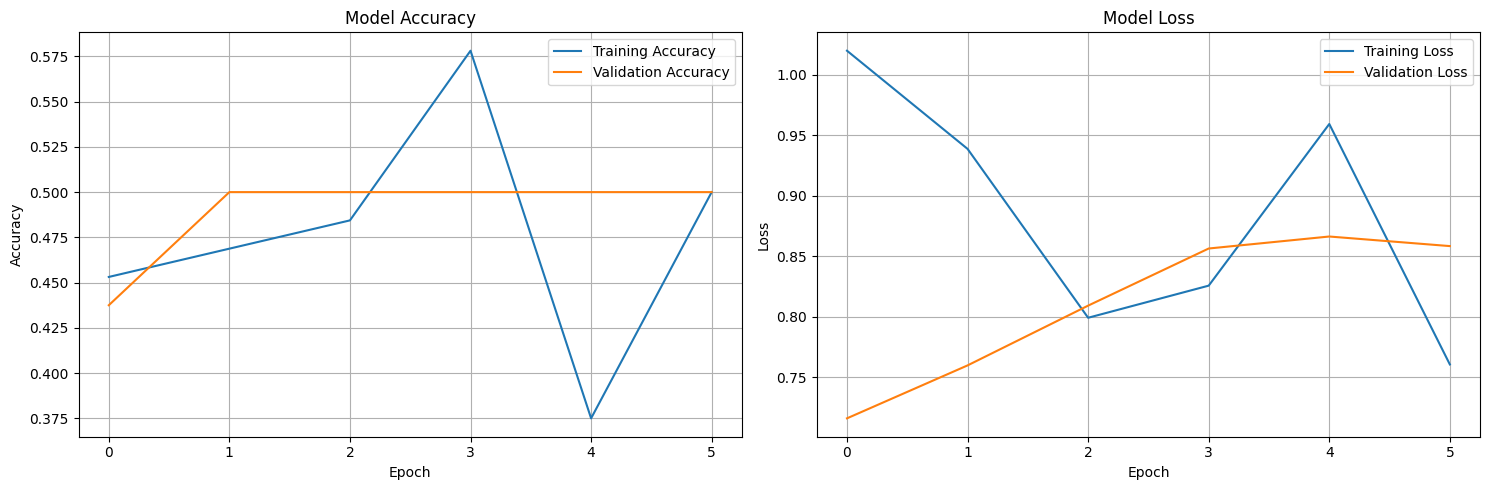

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss
    """
    print(" Plotting training history...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
def evaluate_model(model, X_test, y_test, label_binarizer):
    """
    Evaluate the trained model on test data
    """
    print(" Evaluating model on test data...")

    # Make predictions
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    # Convert true labels back to original format
    y_test_labels = np.argmax(y_test, axis=1)

    # Generate classification report
    print("\n Classification Report:")
    print(classification_report(y_test_labels, predictions,
                              target_names=label_binarizer.classes_))

    # Calculate accuracy
    accuracy = np.mean(predictions == y_test_labels)
    print(f"\n Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return predictions, y_test_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, X_test, y_test, label_binarizer)


 Evaluating model on test data...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(20, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

 Classification Report:
              precision    recall  f1-score   support

   with_mask       0.53      1.00      0.69        10
without_mask       1.00      0.10      0.18        10

    accuracy                           0.55        20
   macro avg       0.76      0.55      0.44        20
weighted avg       0.76      0.55      0.44        20


 Test Accuracy: 0.5500 (55.00%)


In [ ]:
def save_model_and_components(model, label_binarizer):
    """
    Save the trained model and label binarizer
    """
    print(" Saving model and components...")

    # Save the model
    model.save('face_mask_detector.h5')

    # Save label binarizer
    with open('label_binarizer.pkl', 'wb') as f:
        pickle.dump(label_binarizer, f)

    print(" Model and components saved successfully!")
    print(" Files saved:")
    print("   - face_mask_detector.h5")
    print("   - label_binarizer.pkl")

# Save the model
save_model_and_components(model, label_binarizer)

 Saving model and components...
 Model and components saved successfully!
 Files saved:
   - face_mask_detector.h5
   - label_binarizer.pkl


In [ ]:
def load_saved_model():
    """
    Load the saved model and label binarizer
    """
    print(" Loading saved model...")

    # Load model
    model = keras.models.load_model('face_mask_detector.h5')

    # Load label binarizer
    with open('label_binarizer.pkl', 'rb') as f:
        label_binarizer = pickle.load(f)

    print(" Model loaded successfully!")

    return model, label_binarizer

def predict_mask(model, label_binarizer, image):
    """
    Predict if a person in the image is wearing a mask
    """
    # Preprocess image
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    # Make prediction
    prediction = model.predict(image)
    prediction_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    # Get label
    label = label_binarizer.classes_[prediction_class]

    return label, confidence

def detect_face_and_mask(image_path, model, label_binarizer):
    """
    Detect faces and predict mask wearing
    """
    # Load face cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f" Could not load image: {image_path}")
        return None

    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Process each face
    for (x, y, w, h) in faces:
        # Extract face region
        face_roi = image_rgb[y:y+h, x:x+w]

        # Predict mask
        label, confidence = predict_mask(model, label_binarizer, face_roi)

        # Draw bounding box and label
        color = (0, 255, 0) if label == 'with_mask' else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

        # Add label
        text = f"{label}: {confidence:.2f}"
        cv2.putText(image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return image


 Testing model with sample images...
 Loading saved model...


 Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


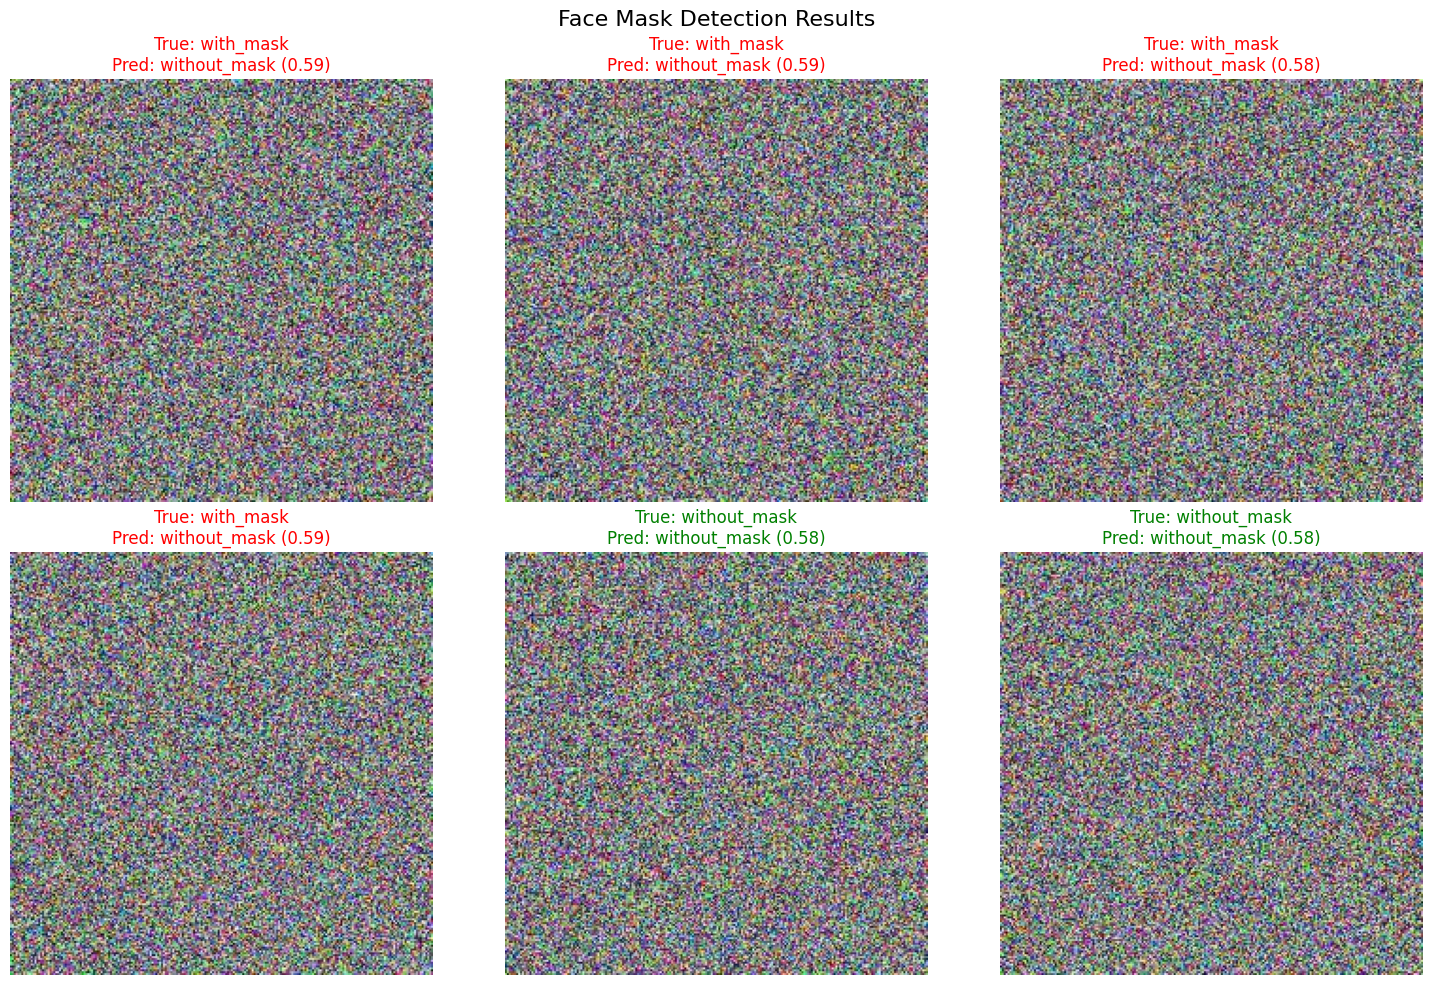

In [ ]:
def test_model_with_samples():
    """
    Test the model with sample images
    """
    print(" Testing model with sample images...")

    # Load the saved model
    model, label_binarizer = load_saved_model()

    # Test with some sample images from test set
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Face Mask Detection Results', fontsize=16)

    for i in range(6):
        if i < len(X_test):
            # Get sample image
            sample_image = X_test[i]
            true_label = label_binarizer.classes_[np.argmax(y_test[i])]

            # Make prediction
            pred_label, confidence = predict_mask(model, label_binarizer, sample_image)

            # Plot
            row = i // 3
            col = i % 3
            axes[row, col].imshow(sample_image)

            # Set title with prediction
            color = 'green' if pred_label == true_label else 'red'
            title = f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})"
            axes[row, col].set_title(title, color=color)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Test the model
test_model_with_samples()
